In [4]:
""""
The notebook is inspired by Tutorial for the Million Song Dataset

by Thierry Bertin-Mahieux (2011) Columbia University
   tb2332@columbia.edu
   Copyright 2011 T. Bertin-Mahieux, All Rights Reserved

The file PythonSrc has been taken from the MSD internet site
""""

SyntaxError: EOL while scanning string literal (1968067104.py, line 7)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys
import time
import glob
import datetime
import sqlite3
import tables
import numpy as np
import seaborn as sns

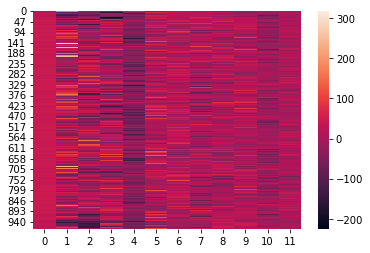

<Figure size 432x288 with 0 Axes>

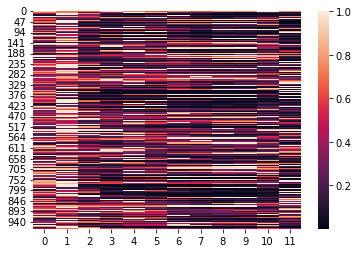

<Figure size 432x288 with 0 Axes>

In [7]:
#get_segments_timbre
path = "C:\\Users\\leand\\Repos\\Music_Classification_git\\PythonSrc\\hdf5_getters.py"
file_alone = "C:\\Users\\leand\\Repos\\Music_Classification_git\\data\\MillionSongSubset\\A\\A\\A\\TRAAAAW128F429D538.h5"
msd_subset_path  = "C:\\Users\\leand\\Repos\\Music_Classification_git\\data\MillionSongSubset"
msd_label_data  = "C:\\Users\\leand\\Repos\\Music_Classification_git\\data\lastfm_subset"
database_file = "C:\\Users\\leand\\Repos\\Music_Classification_git\\data"
msd_subset_data_path=os.path.join(msd_subset_path)
msd_subset_addf_path=os.path.join(database_file)

assert os.path.isdir(msd_subset_path),'wrong path' # sanity check
msd_code_path='./'
assert os.path.isdir(msd_code_path),'wrong path' 
sys.path.append(os.path.join(msd_code_path,'PythonSrc') )
from PythonSrc import hdf5_getters as GETTERS

h5 = GETTERS.open_h5_file_read(file_alone)
duration = GETTERS.get_duration(h5)
timbre_segment = GETTERS.get_segments_timbre(h5)
ax = sns.heatmap(timbre_segment)
fig = plt.figure()
plt.show(ax)
timbre_pitches = GETTERS.get_segments_pitches(h5)
ax2 = sns.heatmap(timbre_pitches)

fig2 = plt.figure()
plt.show(ax2)
import pandas as pd

import json

In [8]:
def apply_to_all_files(basedir,func=lambda x: x,ext='.H5'):
    cnt = 0
    # iterate over all files in all subdirectories
    for root, dirs, files in os.walk(basedir):
        files = glob.glob(os.path.join(root,'*'+ext))
        # count files
        cnt += len(files)
        # apply function to all files
        for f in files :
            func(f)       
    return cnt
print('number of song files:',apply_to_all_files(msd_subset_data_path))
all_artist_names = set()
def func_to_get_artist_name(filename):
    h5 = GETTERS.open_h5_file_read(filename)
    artist_name = GETTERS.get_artist_name(h5)
    all_artist_names.add( artist_name )
    h5.close()

number of song files: 10000


In [9]:
mfcc = np.array([])
track_ids_mfcc = []
def func_to_get_timbre(filename):
    h5 = GETTERS.open_h5_file_read(filename)
    timbre = GETTERS.get_segments_timbre(h5)
    track_id = GETTERS.get_track_id(h5)
    global mfcc
    global track_ids_mfcc
    if(timbre.shape[0] > 300):
        mfcc = np.concatenate((mfcc, np.array([timbre[:300]]))) if mfcc.size else np.array([timbre[:300]])
        track_ids_mfcc += [track_id]
    h5.close()
    
apply_to_all_files(msd_subset_data_path, func=func_to_get_timbre)
print(mfcc.shape)

(9484, 300, 12)


In [10]:
print(len(track_ids_mfcc))

9484


In [11]:
mfcc = mfcc
np.save('data\mfcc.npy', np.array(mfcc))
np.save('data\mfcc_track_id.npy', np.array(track_ids_mfcc))

In [12]:
chroma = np.array([])
track_ids_chroma = []
def func_to_get_pitches(filename):
    h5 = GETTERS.open_h5_file_read(filename)
    pitches = GETTERS.get_segments_pitches(h5)
    track_id = GETTERS.get_track_id(h5)
    global chroma
    global track_ids_chroma
    if(pitches.shape[0] > 300):
        chroma = np.concatenate((chroma, np.array([pitches[:300]]))) if chroma.size else np.array([pitches[:300]])
        track_ids_chroma += [track_id]
    h5.close()
    
apply_to_all_files(msd_subset_data_path, func=func_to_get_pitches)
print(chroma.shape)

(9484, 300, 12)


In [13]:
print(len(track_ids_chroma))

9484


In [14]:
np.save('chroma.npy', np.array(chroma))
np.save('chroma_track_id.npy', np.array(track_ids_chroma))

In [15]:
song_dict = {}
track_dict = {}
def func_to_match_song_and_track(filename):
    h5 = GETTERS.open_h5_file_read(filename)
    song_id = GETTERS.get_song_id(h5)
    track_id = GETTERS.get_track_id(h5)
    global song_dict
    song_dict[song_id] = track_id
    track_dict[track_id] = song_id
    h5.close()

In [16]:
import json
  
# Opening JSON file
def apply_to_all_files_json(basedir,func=lambda x: x,ext='.json'):
   
    cnt = 0
    # iterate over all files in all subdirectories
    for root, dirs, files in os.walk(basedir):
        files = glob.glob(os.path.join(root,'*'+ext))
        # count files
        cnt += len(files)
        # apply function to all files
        for f in files :
            func(f)       
    return cnt

def get_label(filename):
    f = open(filename)
    data = json.load(f)
    global track_ids_json
    global label_json
    if (len(data["tags"])) > 0:
        track_ids_json += [data["track_id"]]
        label_json += [data["tags"][0]]
    

    # Closing file
    f.close()
track_ids_json = []
label_json = []
apply_to_all_files_json(msd_label_data, func=get_label)

9330

In [17]:
track_ids_mfcc_clean = np.array([])
track_ids_chroma_clean = np.array([])
chroma_clean = np.array([])
mfcc_clean = np.array([])
label = np.array([])

#for id_mfcc in range(len(track_ids)):
#        track_ids_chroma[id_mfcc] = track_ids_chroma[id_mfcc].decode("UTF-8")
#        track_ids[id_mfcc] = track_ids[id_mfcc].decode("UTF-8")
counter = 0   
for id_mfcc in range(len(track_ids_mfcc)):
    if (track_ids_mfcc[id_mfcc].decode("UTF-8") in track_ids_json):
        counter = counter + 1
        track_ids_mfcc_clean = np.append(track_ids_mfcc_clean,[track_ids_mfcc[id_mfcc]])
        track_ids_chroma_clean = np.append(track_ids_chroma_clean,[track_ids_chroma[id_mfcc]])
        chroma_clean = np.append(chroma_clean,[[chroma[id_mfcc]]])
        mfcc_clean = np.append(mfcc_clean,mfcc[id_mfcc])



In [18]:
mfcc_clean = np.reshape(mfcc_clean, (len(track_ids_mfcc_clean),300,12))
chroma_clean = np.reshape(chroma_clean, (len(track_ids_chroma_clean),300,12))

In [19]:
label_clean = np.array([])
track_id_clean = np.array([])
track_ids_mfcc_clean_decoded = np.array([])
for i in range(len(track_ids_mfcc_clean)):
    track_ids_mfcc_clean_decoded = np.append(track_ids_mfcc_clean_decoded,[track_ids_mfcc_clean[i].decode("UTF-8")])
for id_json in range(len(track_ids_json)):
    if (track_ids_json[id_json] in track_ids_mfcc_clean_decoded):
        label_clean = np.append(label_clean,[label_json[id_json]])
        track_id_clean = np.append(track_id_clean,[track_ids_json[id_json]])
        
label_clean = np.reshape(label_clean, (len(track_id_clean),1,2))


print(np.shape(label_clean))
print(np.shape(track_id_clean))
print(np.shape(track_ids_mfcc_clean))
print(np.shape(track_ids_chroma_clean))
print(np.shape(mfcc_clean))
print(np.shape(chroma_clean))

(4641, 1, 2)
(4641,)
(4641,)
(4641,)
(4641, 300, 12)
(4641, 300, 12)


In [20]:
np.save('label_clean.npy', np.array(label_clean))
np.save('track_id_clean.npy', np.array(track_id_clean))

np.save('track_ids_mfcc_clean.npy', np.array(track_ids_mfcc_clean))

np.save('track_ids_chroma_clean.npy', np.array(track_ids_chroma_clean))

np.save('mfcc_clean.npy', np.array(mfcc_clean))

np.save('chroma_clean.npy', np.array(chroma_clean))

b'TRAABVM128F92CA9DC'
b'TRAABVM128F92CA9DC'
TRAABVM128F92CA9DC
[['hard rock' '100']]


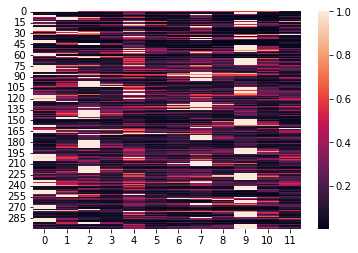

<Figure size 432x288 with 0 Axes>

In [21]:

print(track_ids_mfcc_clean[10])
print(track_ids_chroma_clean[10])
print(track_id_clean[10])
print(label_clean[10])

ax2 = sns.heatmap(chroma_clean[10])
fig2 = plt.figure()
plt.show(ax2)

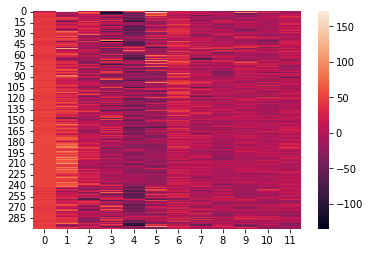

<Figure size 432x288 with 0 Axes>

In [22]:
ax1 = sns.heatmap(mfcc_clean[10])
fig1 = plt.figure()
plt.show(ax1)

In [23]:
genre_dict = {}
genre_set = set()

In [25]:
import json
counting = 0
with open('data/msd_tagtraum_cd2.cls', 'r') as fp:
    lines = fp.readlines()
    for i in range(7, len(lines)):
        split = lines[i].strip().split()
        genre_set.add(split[1])
        
        #trackid_tagtraum = np.append(trackid_tagtraum,[split[0]])
        genre_dict[split[0]] = split[1]

In [26]:

with open('data/track-genre-mapping.json', 'w') as fp:
    json.dump(genre_dict, fp)

In [27]:
track_ids_tagtraum = []
genre_tagtraum = []
for trackid in track_ids_mfcc:
    if trackid.decode("UTF-8") in genre_dict:
        genre_tagtraum += [genre_dict[trackid.decode("UTF-8")]]
        track_ids_tagtraum += [trackid.decode("UTF-8")]

In [28]:
chroma_tagtraum_clean = np.array([])
mfcc_tagtraum_clean = np.array([])
for id_mfcc in range(len(track_ids_mfcc)):
    if (track_ids_mfcc[id_mfcc].decode("UTF-8") in track_ids_tagtraum):
        mfcc_tagtraum_clean = np.append(mfcc_tagtraum_clean,mfcc[id_mfcc])
        chroma_tagtraum_clean = np.append(chroma_tagtraum_clean,chroma[id_mfcc])

In [ ]:
mfcc_tagtraum_clean = np.reshape(mfcc_tagtraum_clean, (len(track_ids_tagtraum),300,12))
chroma_tagtraum_clean = np.reshape(chroma_tagtraum_clean, (len(track_ids_tagtraum),300,12))

In [ ]:
print(np.shape(mfcc_tagtraum_clean))
print(np.shape(chroma_tagtraum_clean))
print(len(track_ids_tagtraum))
print(len(genre_tagtraum))
print(len(np.unique(genre_tagtraum)))
print(len(np.unique(track_ids_tagtraum)))

In [ ]:
np.save('mfcc_tagtraum_clean.npy', np.array(mfcc_tagtraum_clean))
np.save('chroma_tagtraum_clean.npy', np.array(chroma_tagtraum_clean))

np.save('genre_tagtraum.npy', np.array(genre_tagtraum))

np.save('track_ids_tagtraum.npy', np.array(track_ids_tagtraum))

<class 'list'>
<class 'list'>
